In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing zeolite synthesis descriptors

In [2]:
import os
from math import e, log, pi, sqrt
from warnings import simplefilter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from analysis_functions import (
    SYNTH_TEMP,
    compare_aucs,
    my_mpl_settings,
    parse_sisso_eqn,
    plot_recall_curves,
    remove_outliers,
)
from constants import K_BOLTZMANN
from matplotlib import cm
from scipy.special import softmax
from tqdm import tqdm

In [3]:
# Pandas complains about performance warnings when adding too many columns
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# some runtime warnings are expected and can be ignored when evaluating SISSO expressions
simplefilter(action="ignore", category=RuntimeWarning)

In [4]:
my_mpl_settings()

TODOs:

- [ ] remove any extraneous code that was not part of the analysis for the manuscript
- [ ] update variable names throughout so the notebook runs smoothly (though make sure you don't delete any data!!)
- [ ] update analysis so that it runs on the same dataset for all descriptors (as much as possible)

# Preparing the data for a SISSO run

I want to change the following things in the dataframe before exporting it for a SISSO run:
- add formation energies for the frameworks (will not include entropy estimates)
- compute formation $C$ and $D$ by mixing and matching formation energies with Helmholtz free energies
- change $C$ and $D$ values to logs
- remove any extraneous columns
- check to see which, if any, variables correlate with one another and remove redundant ones (with $\rho > 0.7$)
- rename the columns so the names are a reasonable length for SISSO
- export the full dataset in SISSO-readable format and a sample (for the actual run)

# Analyze SISSO equations

In [5]:
full_df = pd.read_csv("../data/clean_all_data.csv")
print(len(full_df))
full_df.head()

74789


,crystal_id,Zeolite,SMILES,Ligand formula,Loading,dE_S,dE_Om,Templating,Volume (Angstrom3),syn,...,lC_fOa,lC_fS,lD_fOa,lD_fS,lC_Om,lD_Om,lC_AOm,lD_AOm,lC_fOm,lD_fOm
0,137337790,ACO,CCCCCN,C5H13N,2,-0.792990,-6.343916,19.428617,107.680,0.0,...,-3.763081,-5.177063,-5.462692,-7.613363,-21.215128,-40.662536,-24.096644,-51.616742,-32.810746,-36.236019
1,137353625,ACO,Cc1ccncc1,C6H7N,2,-3.000776,-24.006207,18.325914,96.232,0.0,...,-3.998696,-4.513224,-5.956683,-7.434522,-15.904415,-33.432341,-18.533953,-43.677207,-27.500033,-36.977180
2,137369986,ACO,NCCOCCO,C4H11NO2,3,-7.733204,-41.243755,15.525417,108.720,0.0,...,-2.634592,-3.090273,-4.440724,-5.831656,-10.721414,-33.119391,-14.687604,-43.094288,-10.776070,-20.026711
3,137352553,ACO,CCNCC,C4H11N,2,-2.536347,-20.290778,18.026902,91.104,0.0,...,-3.823833,-4.652868,-5.517742,-7.004148,-17.021574,-29.886585,-18.562155,-39.813323,-28.617192,-30.623784
4,139638010,ACO,CCCCN,C4H11N,3,-1.885987,-10.058597,19.195592,90.800,0.0,...,-3.294812,-4.848419,-5.252069,-7.667084,-20.098195,-38.772090,-21.736081,-45.225110,-20.152850,-27.230365


In [6]:
cols = [i for i in full_df.columns if "sisso" not in i]
print(cols)

['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S', 'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads', 'ligand_atoms', 'dE_Oa', 'E_F', 'Si_count', 'dA_Om', 'dA_Oa', 'dA_S', 'dE_fOm', 'dE_fOa', 'dE_fS', 'dA_fS', 'E_T', 'E_fT', 'A_T', 'lC_Oa', 'lC_S', 'lD_Oa', 'lD_S', 'lC_AOa', 'lC_AS', 'lD_AOa', 'lD_AS', 'lC_fOa', 'lC_fS', 'lD_fOa', 'lD_fS', 'lC_Om', 'lD_Om', 'lC_AOm', 'lD_AOm', 'lC_fOm', 'lD_fOm']


## Parse the SISSO equations

This repository should contain a CSV file where the outputs of the SISSO run are parsed and evaluated for each row. However, we include the code to create the file for reproducibility (the following code cells should not run if the output file exists).

In [7]:
with open("../data/sisso_expressions.txt") as f:
    sisso_expressions = [line.strip() for line in f]

## Assess literature recall

In [8]:
fhand = "../data/top_sisso_all_idx.txt"
if os.path.exists(fhand):
    with open(fhand) as f:
        top_sisso_all_idx = [int(i) for i in f.readlines()]

In [9]:
top_sisso_all_expr = [f"sisso_{sis:05d}" for sis in top_sisso_all_idx]

In [10]:
nonsis_cols = [col for col in full_df.columns if "sisso" not in col]
print(nonsis_cols)

['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S', 'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads', 'ligand_atoms', 'dE_Oa', 'E_F', 'Si_count', 'dA_Om', 'dA_Oa', 'dA_S', 'dE_fOm', 'dE_fOa', 'dE_fS', 'dA_fS', 'E_T', 'E_fT', 'A_T', 'lC_Oa', 'lC_S', 'lD_Oa', 'lD_S', 'lC_AOa', 'lC_AS', 'lD_AOa', 'lD_AS', 'lC_fOa', 'lC_fS', 'lD_fOa', 'lD_fS', 'lC_Om', 'lD_Om', 'lC_AOm', 'lD_AOm', 'lC_fOm', 'lD_fOm']


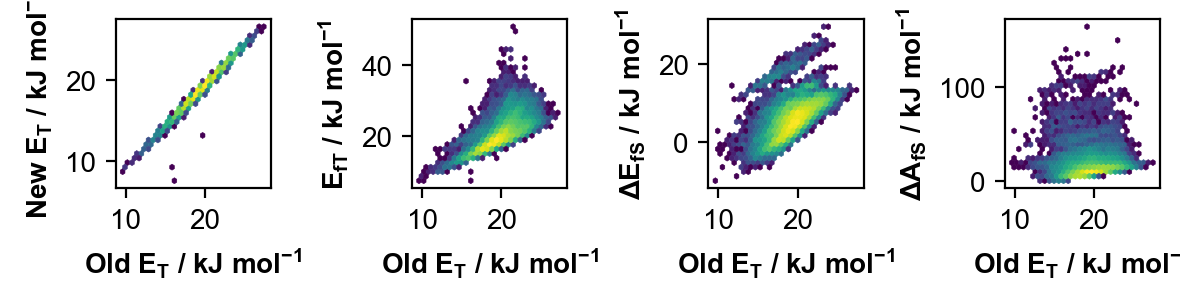

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(6, 1.6))
plotvars = ["E_T", "E_fT", "dE_fS", "dA_fS"]
labels = [
    "New $\mathdefault{E}_{\mathdefault{T}}$ / kJ mol$^{\mathdefault{-1}}$",
    "$\mathdefault{E}_{\mathdefault{fT}}$ / kJ mol$^{\mathdefault{-1}}$",
    "$\mathdefault{\Delta E}_{\mathdefault{fS}}$ / kJ mol$^{\mathdefault{-1}}$",
    "$\mathdefault{\Delta A}_{\mathdefault{fS}}$ / kJ mol$^{\mathdefault{-1}}$",
]

for i, vv in enumerate(plotvars):
    axes[i].hexbin(
        full_df["Templating"],
        full_df[vv],
        gridsize=30,
        cmap="viridis",
        bins="log",
        linewidths=0.2,
    )
    axes[i].set_ylabel(labels[i], fontweight="bold")
    axes[i].set_xlabel(
        "Old $\mathdefault{E}_{\mathdefault{T}}$ / kJ mol$^{\mathdefault{-1}}$",
        fontweight="bold",
    )

fig.tight_layout()

In [12]:
full_df.head()

,crystal_id,Zeolite,SMILES,Ligand formula,Loading,dE_S,dE_Om,Templating,Volume (Angstrom3),syn,...,lC_fOa,lC_fS,lD_fOa,lD_fS,lC_Om,lD_Om,lC_AOm,lD_AOm,lC_fOm,lD_fOm
0,137337790,ACO,CCCCCN,C5H13N,2,-0.792990,-6.343916,19.428617,107.680,0.0,...,-3.763081,-5.177063,-5.462692,-7.613363,-21.215128,-40.662536,-24.096644,-51.616742,-32.810746,-36.236019
1,137353625,ACO,Cc1ccncc1,C6H7N,2,-3.000776,-24.006207,18.325914,96.232,0.0,...,-3.998696,-4.513224,-5.956683,-7.434522,-15.904415,-33.432341,-18.533953,-43.677207,-27.500033,-36.977180
2,137369986,ACO,NCCOCCO,C4H11NO2,3,-7.733204,-41.243755,15.525417,108.720,0.0,...,-2.634592,-3.090273,-4.440724,-5.831656,-10.721414,-33.119391,-14.687604,-43.094288,-10.776070,-20.026711
3,137352553,ACO,CCNCC,C4H11N,2,-2.536347,-20.290778,18.026902,91.104,0.0,...,-3.823833,-4.652868,-5.517742,-7.004148,-17.021574,-29.886585,-18.562155,-39.813323,-28.617192,-30.623784
4,139638010,ACO,CCCCN,C4H11N,3,-1.885987,-10.058597,19.195592,90.800,0.0,...,-3.294812,-4.848419,-5.252069,-7.667084,-20.098195,-38.772090,-21.736081,-45.225110,-20.152850,-27.230365


Add new equations to the full dataframe

In [13]:
fhand = "../data/var_names.txt"
with open(fhand) as f:
    variable_names = [i.strip() for i in f.readlines()]

In [14]:
for jj, idx in tqdm(enumerate(top_sisso_all_idx)):
    colname = f"sisso_{idx:05d}"
    eq = sisso_expressions[idx]
    new_sis_eqn = parse_sisso_eqn(eq, variable_names, "full_df")
    try:
        full_df[colname] = eval(new_sis_eqn)
    except TypeError:
        print("Failed to evaluate expression: ", eq)

192it [00:00, 888.10it/s]

601it [00:00, 794.41it/s]


In [15]:
substrates = set(full_df["Zeolite"].tolist())

In [16]:
stability_metrics = [
    "E_T",
    "E_fT",
    "A_T",
    "dE_fS",
    "dA_fS",
    "Templating",
    *top_sisso_all_expr,
]

In [17]:
full_df = full_df.dropna(axis=1)
len(full_df.columns)

613

In [18]:
stability_metrics = [metric for metric in stability_metrics if metric in full_df.columns]
len(stability_metrics)

576

In [19]:
"dA_fS" in full_df.columns

True

In [20]:
new_top_sissos = [col for col in full_df.columns if "sisso" in col]

In [21]:
idxmin = full_df.groupby(["Zeolite", "SMILES"]).idxmin()

In [22]:
idxmin.head()

crystal_id  Ligand formula  Loading  dE_S  dE_Om  Templating  \
Zeolite SMILES                                                                 
ACO     CCCCCN           0               0        0     0      0           0   
        CCCCN            4               4        4     4      4           4   
        CCCCO            9               9        9     9      9           9   
        CCNC             8               8        8     8      8           8   
        CCNCC            3               3        3     3      3           3   

                Volume (Angstrom3)  syn  TdS_ads  ligand_atoms  ...  \
Zeolite SMILES                                                  ...   
ACO     CCCCCN                   0    0        0             0  ...   
        CCCCN                    4    4        4             4  ...   
        CCCCO                    9    9        9             9  ...   
        CCNC                     8    8        8             8  ...   
        CCNCC                    3    3        3             3  ...   

                sisso_08339  sisso_08991  sisso_44960  sisso_13971  \
Zeolite SMILES                                                       
ACO     CCCCCN            0            0            0            0   
        CCCCN             4            4            4            4   
        CCCCO             9            9            9            9   
        CCNC              8            8            8            8   
        CCNCC             3            3            3            3   

                sisso_01161  sisso_15827  sisso_33407  sisso_17347  \
Zeolite SMILES                                                       
ACO     CCCCCN            0            0            0            0   
        CCCCN             4            4            4            4   
        CCCCO             9            9            9            9   
        CCNC              8            8            8            8   
        CCNCC             3            3            3            3   

                sisso_31819  sisso_13229  
Zeolite SMILES                            
ACO     CCCCCN            0            0  
        CCCCN             4            4  
        CCCCO             9            9  
        CCNC              8            8  
        CCNCC             3            3  

[5 rows x 611 columns]

### Recompute some of the metrics

Because we are fitting logistic curves and decision trees, their performance metrics are agnostic to the "direction" of the function (_i.e._, if the logistic curves puts synthesized OSDA-zeo pairs at low values of a descriptor and unsynthesized pairs at the high end); however, the rankings depend on the pairs being ranked in a particular way. As such, if there were any metrics where the normalized AUC recall was $< 0.5$, then we'll recalculate the descriptor with a negative sign (which has the same effect as computing a logistic curve with $-x$ so the rankings are reversed).

In [23]:
auc_fhand = "../data/auc_avg.csv"
comp_fhand = "../data/auc_comp.csv"
auc_calc_exists = os.path.exists(auc_fhand) and os.path.exists(comp_fhand)

In [ ]:
if not auc_calc_exists:
    auc_comp = compare_aucs(
        df=full_df,
        idxmin=idxmin,
        substrates=substrates,
        syn_col="syn",
        sort_values="norm_auc",
        metrics=stability_metrics,
    )
    auc_comp.head()

In [28]:
if not auc_calc_exists:
    auc_avs = {}
    for metric in stability_metrics:
        auc_avs[metric] = auc_comp[metric].mean()

In [29]:
if not auc_calc_exists:
    auc_avg = pd.Series(auc_avs).sort_values(ascending=False)
    bad_metrics = [metric for metric in stability_metrics if auc_avs[metric] < 0.5]
else:
    auc_avg = pd.read_csv(auc_fhand, index_col=0)
    auc_avg = auc_avg.squeeze()
    auc_avs = auc_avg.to_dict()
    bad_metrics = auc_avg[auc_avg < 0.5].index.to_list()

len(bad_metrics)

0

In [30]:
auc_avg.tail()

sisso_23440    0.509930
sisso_34058    0.505407
sisso_49884    0.504015
sisso_49870    0.504015
sisso_14981    0.500075
Name: 0, dtype: float64

Some of the expressions have an AUC < 0.5. Let's make a list of those expressions and compute those colums as their negative (so that the OSDA rankings correspond to order expected by the AUC code) then recompute the AUCs.

In [31]:
if not auc_calc_exists:
    for metric in bad_metrics:
        full_df[metric] = -full_df[metric]

In [32]:
if len(bad_metrics) > 0 and not auc_calc_exists:
    auc_comp = compare_aucs(
        df=full_df,
        idxmin=idxmin,
        substrates=substrates,
        syn_col="syn",
        sort_values="norm_auc",
        metrics=stability_metrics,
    )
    auc_avs = {}
if auc_calc_exists:
    auc_comp = pd.read_csv(comp_fhand, index_col=0)

In [33]:
for metric in stability_metrics:
    auc_avs[metric] = auc_comp[metric].mean()

bad_metrics = [metric for metric in stability_metrics if auc_avs[metric] < 0.5]
auc_avg = pd.Series(auc_avs).sort_values(ascending=False)

In [34]:
# save for later
if not auc_calc_exists:
    auc_avg.to_csv(auc_fhand)
    auc_comp.to_csv(comp_fhand)

In [35]:
auc_comp

,A_T,E_T,E_fT,Templating,dA_fS,dE_fS,sisso_00172,sisso_00356,sisso_00395,sisso_00429,...,sisso_49166,sisso_49210,sisso_49233,sisso_49299,sisso_49302,sisso_49674,sisso_49842,sisso_49870,sisso_49884,sisso_49944
zeolite,,,,,,,,,,,,,,,,,,,,,
ACO,0.500000,0.909091,0.909091,0.909091,0.454545,0.909091,1.000000,1.000000,0.590909,0.090909,...,0.954545,0.954545,0.454545,0.954545,0.909091,0.772727,0.954545,0.909091,0.909091,0.727273
AEI,0.879103,0.870220,0.852115,0.863931,0.869487,0.861393,0.628032,0.843147,0.852651,0.859334,...,0.733728,0.856740,0.848759,0.770079,0.660632,0.856486,0.860745,0.649549,0.649549,0.885082
AFI,0.540093,0.507269,0.408817,0.492038,0.536177,0.530988,0.520140,0.657992,0.511709,0.519260,...,0.538707,0.502623,0.401229,0.539568,0.483064,0.565498,0.537863,0.468600,0.468600,0.346260
AFN,0.626018,0.656980,0.417708,0.641771,0.650733,0.609723,0.571972,0.769419,0.704780,0.597773,...,0.612167,0.290603,0.329712,0.614068,0.457089,0.417708,0.595872,0.355242,0.355242,0.366105
AFR,0.218471,0.196624,0.272095,0.208540,0.252731,0.235849,0.391758,0.151936,0.290963,0.241807,...,0.197617,0.338133,0.399206,0.192651,0.204071,0.565045,0.230884,0.536743,0.536743,0.200596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UFI,0.684623,0.761019,0.664545,0.752204,0.796768,0.793830,0.735553,0.939765,0.716944,0.545054,...,0.823213,0.836435,0.549951,0.824682,0.744368,0.749755,0.784525,0.659647,0.659647,0.562194
USI,0.281974,0.496475,0.512252,0.468614,0.294394,0.691172,0.588453,0.686808,0.255455,0.250755,...,0.658275,0.679423,0.682108,0.654246,0.681101,0.768714,0.697885,0.750252,0.750252,0.558577
UTL,0.466151,0.443324,0.403802,0.464472,0.425031,0.380195,0.523473,0.489740,0.531435,0.490575,...,0.398946,0.380222,0.373194,0.400122,0.371084,0.376883,0.377170,0.577420,0.577420,0.388274


In [36]:
auc_avg.head()

sisso_13229    0.718479
sisso_31819    0.713719
sisso_31770    0.713719
sisso_48469    0.710772
sisso_02923    0.709460
dtype: float64

In [37]:
best_sisso = auc_avg.index[0]
print(best_sisso)

sisso_13229


In [38]:
best_stab_metrics = [
    best_sisso,
    "E_T",
    "E_fT",
    "dE_fS",
    "A_T",
    "dA_fS",
    "Templating",
]

In [39]:
best_fhand = "../data/best_sisso_stability_metrics.csv"
if not os.path.exists(best_fhand):
    print("Writing the best stability metrics to a file...")
    cols = list(
        {
            "syn",
            "Zeolite",
            "SMILES",
            "Templating",
            "A_T",
            *variable_names,
            *best_stab_metrics,
        }
    )
    best_df = full_df[cols]
    best_df.to_csv(best_fhand, index=False)

else:
    print("Reading the best stability metrics from a file...")
    best_df = pd.read_csv(best_fhand)

Reading the best stability metrics from a file...


In [40]:
auc_avg[best_stab_metrics]

sisso_13229    0.718479
E_T            0.683519
E_fT           0.679661
dE_fS          0.687664
A_T            0.629111
dA_fS          0.619242
Templating     0.679371
dtype: float64

In [41]:
best_df.columns

Index(['dE_fS', 'Templating', 'lD_Oa', 'sisso_13229', 'dE_S', 'Zeolite',
       'SMILES', 'dE_Oa', 'syn', 'dE_fOm', 'dA_fS', 'E_T', 'lC_S', 'lC_Oa',
       'lC_Om', 'dE_Om', 'lD_Om', 'lC_fS', 'dE_fOa', 'lD_S', 'lD_fS', 'A_T',
       'lC_fOa', 'E_fT', 'E_F'],
      dtype='object')

### Add AUC std. dev. to the analysis to see if any high-performing metrics also have big spans in their recalls across frameworks

In [42]:
auc_stddevs = {}
for metric in stability_metrics:
    auc_stddevs[metric] = auc_comp[metric].std()

auc_stddevs = pd.Series(auc_stddevs).sort_values(ascending=False)

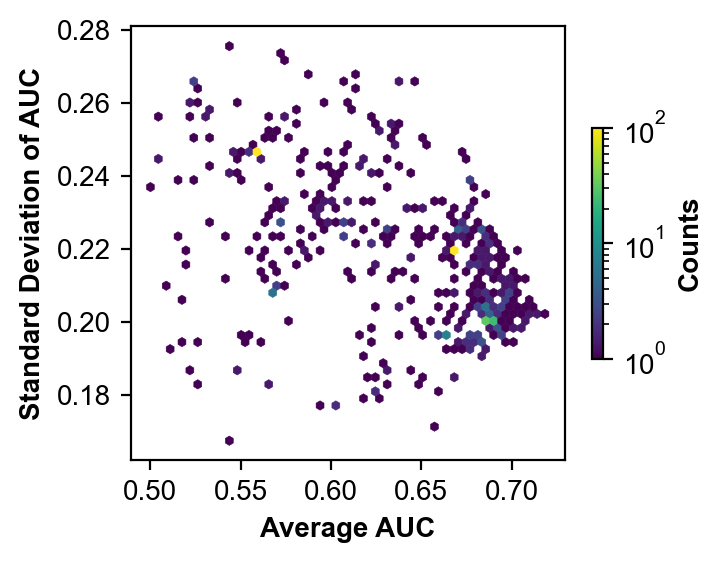

In [43]:
auc_avg_order = [auc_avs[metric] for metric in stability_metrics]
auc_stddev_order = [auc_stddevs[metric] for metric in stability_metrics]

cmap = mpl.colormaps["viridis"]
normalizer = mpl.colors.LogNorm(vmin=1, vmax=100)
scalar_mappable = cm.ScalarMappable(norm=normalizer, cmap=cmap)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
im = ax.hexbin(
    auc_avg_order,
    auc_stddev_order,
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    linewidths=0.2,
)
ax.set_xlabel("Average AUC", fontweight="bold")
ax.set_ylabel("Standard Deviation of AUC", fontweight="bold")
cb = fig.colorbar(scalar_mappable, ax=ax, shrink=0.5)
cb.set_label("Counts", fontweight="bold")
ax.set_box_aspect(1)
plt.show()

## Also compare performance for OSDA AUC

I want to try to do the same thing as above but where I do AUC for OSDA rather than zeolite framework. I will do this only for the top performing equations for zeolite AUCs that I have in my existing "best" list.

In [44]:
osdas = best_df["SMILES"].unique().tolist()

In [45]:
osda_idxmin = best_df.groupby(
    [
        "SMILES",
        "Zeolite",
    ]
).idxmin()

In [46]:
auc_comp_mini = compare_aucs(
    df=best_df,
    idxmin=osda_idxmin,
    substrates=osdas,
    syn_col="syn",
    sort_values="norm_auc",
    metrics=best_stab_metrics,
)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


In [47]:
auc_comp_mini.head()

metric,A_T,E_T,E_fT,Templating,dA_fS,dE_fS,sisso_13229
zeolite,,,,,,,
C(CCCC[N+]12CCN(CC1)CC2)CCC[N+]12CCN(CC1)CC2,0.173913,0.173913,0.217391,0.173913,0.478261,0.434783,0.478261
C(CCC[N+]12CCC(CC1)CC2)CC[N+]12CCC(CC1)CC2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846154
C(CCC[N+]12CCC(CC1)CN2)CC[N+]12CCC(CC1)CN2,0.851852,0.777778,0.814815,0.777778,1.000000,0.962963,0.777778
C(CCC[N+]12CCN(CC1)CC2)CC[N+]12CCN(CC1)CC2,1.000000,0.925926,0.925926,0.925926,1.000000,1.000000,0.962963
C(CCN1CCOCCOCCOCCOCC1)CCN1CCOCCOCCOCCOCC1,0.909091,0.909091,0.818182,0.909091,0.636364,0.545455,0.454545


In [48]:
auc_avs_mini = {}
for metric in best_stab_metrics:
    auc_avs_mini[metric] = auc_comp_mini[metric].mean()

In [49]:
auc_avg_mini = pd.Series(auc_avs_mini).sort_values(ascending=False)
auc_avg_mini

dE_fS          0.722518
sisso_13229    0.716087
dA_fS          0.685606
E_fT           0.684427
E_T            0.674763
Templating     0.674695
A_T            0.629083
dtype: float64

In [50]:
full_df["lD_Om"].describe()

count    74789.000000
mean       -21.397573
std         14.886567
min       -122.261284
25%        -28.531169
50%        -17.626189
75%        -10.740485
max          0.000000
Name: lD_Om, dtype: float64

In [51]:
full_df.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn',
       ...
       'sisso_08339', 'sisso_08991', 'sisso_44960', 'sisso_13971',
       'sisso_01161', 'sisso_15827', 'sisso_33407', 'sisso_17347',
       'sisso_31819', 'sisso_13229'],
      dtype='object', length=613)

# Compare new equations to the old templating energy

In this section, I'll make plots that compare the new equations to the old $E_T$ and check how they correlate with $E_T$: 

- $E_{form,aff,Si}$
- $E_{form,T}$
- $A_T$
- $\alpha_T$

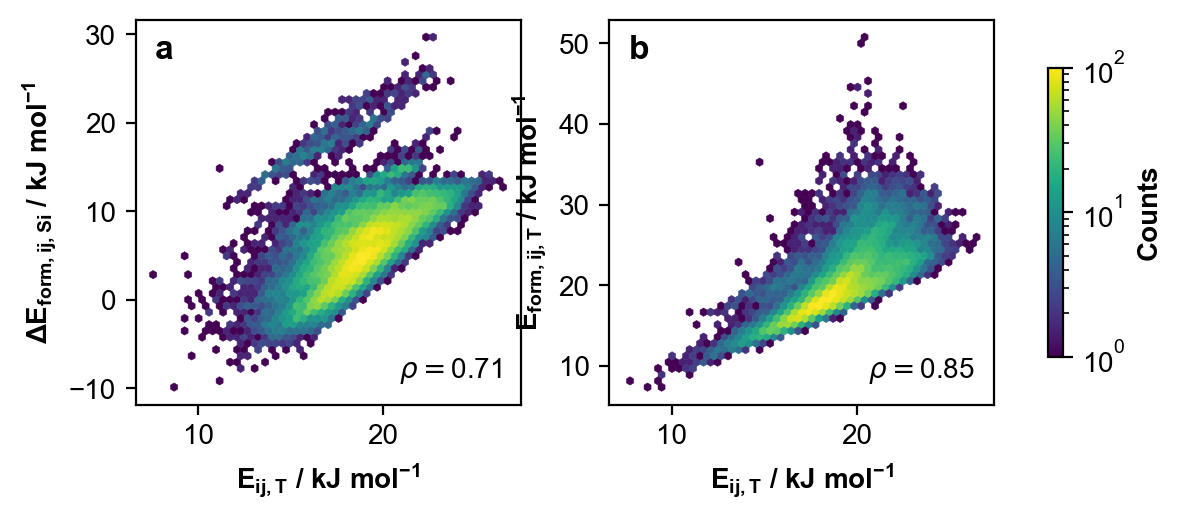

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))
cmap = mpl.colormaps["viridis"]
normalizer = mpl.colors.LogNorm(vmin=1, vmax=100)
scalar_mappable = cm.ScalarMappable(norm=normalizer, cmap=cmap)

# compute spearman correlation for both plots
form_aff_spearman = best_df["E_T"].corr(best_df["dE_fS"], method="spearman")
form_template_spearman = best_df["E_T"].corr(best_df["E_fT"], method="spearman")

axes[0].hexbin(
    best_df["E_T"],
    best_df["dE_fS"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    linewidths=0.2,
)
axes[0].set_xlabel(
    "$\mathdefault{E}_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
axes[0].set_ylabel(
    "$\mathdefault{\Delta E}_{\mathdefault{form,ij,Si}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
axes[0].annotate(
    "a",
    xy=(0.05, 0.88),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
axes[0].annotate(
    r"$\rho =$" f"{form_aff_spearman:.2f}",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=10,
)

axes[1].hexbin(
    best_df["E_T"],
    best_df["E_fT"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    linewidths=0.2,
)
axes[1].set_xlabel(
    "$\mathdefault{E}_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
axes[1].set_ylabel(
    "$\mathdefault{E}_{\mathdefault{form,ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
axes[1].annotate(
    "b",
    xy=(0.05, 0.88),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
axes[1].annotate(
    r"$\rho =$" f"{form_template_spearman:.2f}",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=10,
)

for ax in axes:
    ax.set_box_aspect(1)

cb = fig.colorbar(scalar_mappable, ax=axes.ravel().tolist(), shrink=0.75)
cb.set_label("Counts", fontweight="bold")
# plt.tight_layout()
fig.savefig("images/dE_metric_templating.svg", dpi=300, bbox_inches="tight")
plt.show()

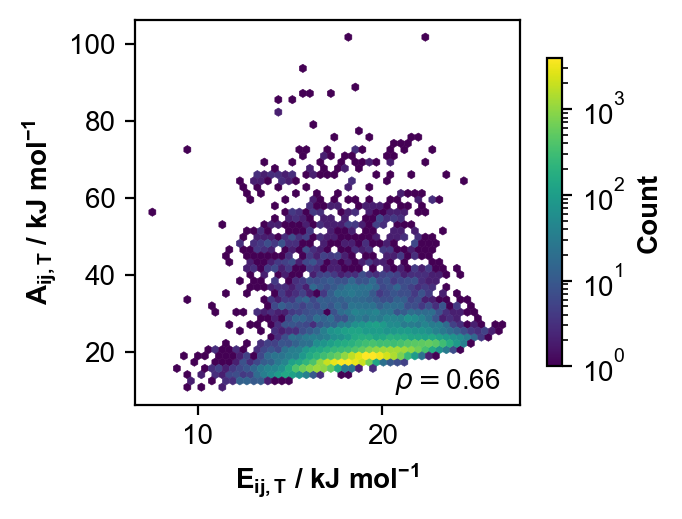

In [53]:
extent = [
    best_df["E_T"].min(),
    best_df["E_T"].max(),
    best_df["A_T"].min(),
    best_df["A_T"].max(),
]

spearman = best_df["E_T"].corr(best_df["A_T"], method="spearman")

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))

im = ax.hexbin(
    best_df["E_T"],
    best_df["A_T"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    linewidth=0.2,
    extent=extent,
)
cb = fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_xlabel(
    "$\mathdefault{E}_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)
ax.set_ylabel(
    "$\mathdefault{A}_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",  # noqa: W605
    fontweight="bold",
)
ax.annotate(
    r"$\rho =$" f"{spearman:.2f}",
    (0.95, 0.02),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=10,
)
cb.set_label("Count", fontweight="bold")
ax.set_box_aspect(1)
fig.savefig("images/helmholtz_templating.svg", dpi=300, bbox_inches="tight")

3it [00:00,  5.21it/s]


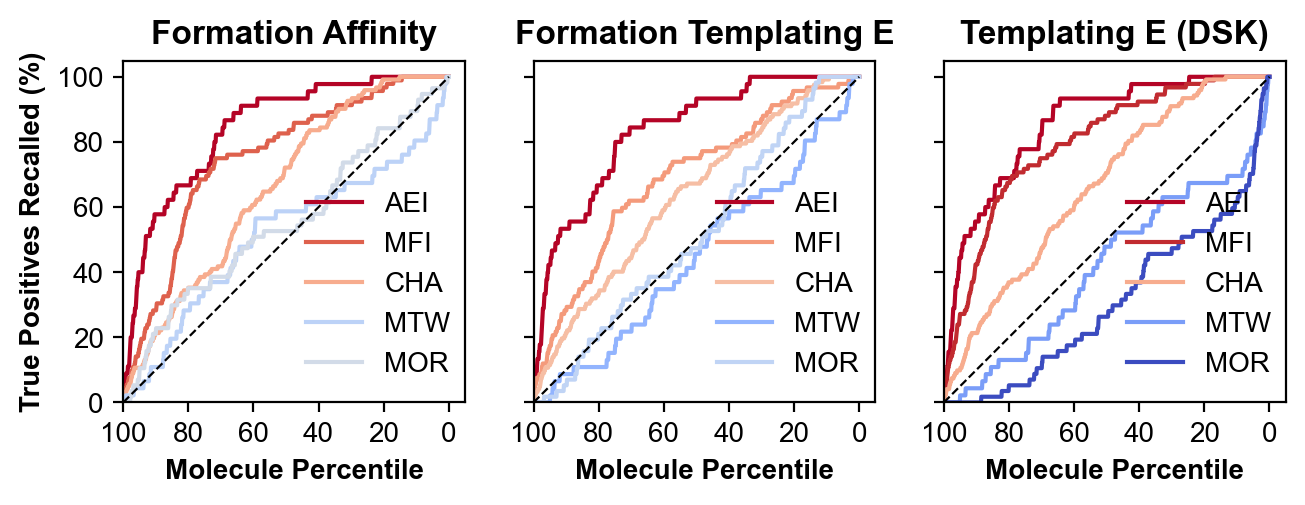

In [54]:
norm = mpl.colors.Normalize(vmin=0.3, vmax=0.85)
cmap = cm.coolwarm
to_plot = ["AEI", "MFI", "CHA", "MTW", "MOR"]
metrics = ["dE_fS", "E_fT", "E_T"]

fig, ax = plot_recall_curves(
    lit_df=full_df,
    idxmin=idxmin,
    metrics=metrics,
    plot_items=to_plot,
    substance="zeolite",
    cmap=cmap,
)

# DSK templating
ax[0].set_title("Formation Affinity", fontweight="bold")
ax[1].set_title("Formation Templating E", fontweight="bold")
ax[2].set_title("Templating E (DSK)", fontweight="bold")

fig.savefig("images/recall_examples.svg", bbox_inches="tight")

plt.show()

In [57]:
auc_comp.head()

,A_T,E_T,E_fT,Templating,dA_fS,dE_fS,sisso_00172,sisso_00356,sisso_00395,sisso_00429,...,sisso_49166,sisso_49210,sisso_49233,sisso_49299,sisso_49302,sisso_49674,sisso_49842,sisso_49870,sisso_49884,sisso_49944
zeolite,,,,,,,,,,,,,,,,,,,,,
ACO,0.500000,0.909091,0.909091,0.909091,0.454545,0.909091,1.000000,1.000000,0.590909,0.090909,...,0.954545,0.954545,0.454545,0.954545,0.909091,0.772727,0.954545,0.909091,0.909091,0.727273
AEI,0.879103,0.870220,0.852115,0.863931,0.869487,0.861393,0.628032,0.843147,0.852651,0.859334,...,0.733728,0.856740,0.848759,0.770079,0.660632,0.856486,0.860745,0.649549,0.649549,0.885082
AFI,0.540093,0.507269,0.408817,0.492038,0.536177,0.530988,0.520140,0.657992,0.511709,0.519260,...,0.538707,0.502623,0.401229,0.539568,0.483064,0.565498,0.537863,0.468600,0.468600,0.346260
AFN,0.626018,0.656980,0.417708,0.641771,0.650733,0.609723,0.571972,0.769419,0.704780,0.597773,...,0.612167,0.290603,0.329712,0.614068,0.457089,0.417708,0.595872,0.355242,0.355242,0.366105
AFR,0.218471,0.196624,0.272095,0.208540,0.252731,0.235849,0.391758,0.151936,0.290963,0.241807,...,0.197617,0.338133,0.399206,0.192651,0.204071,0.565045,0.230884,0.536743,0.536743,0.200596


/tmp/ipykernel_1231508/211045531.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_1231508/211045531.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_1231508/211045531.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


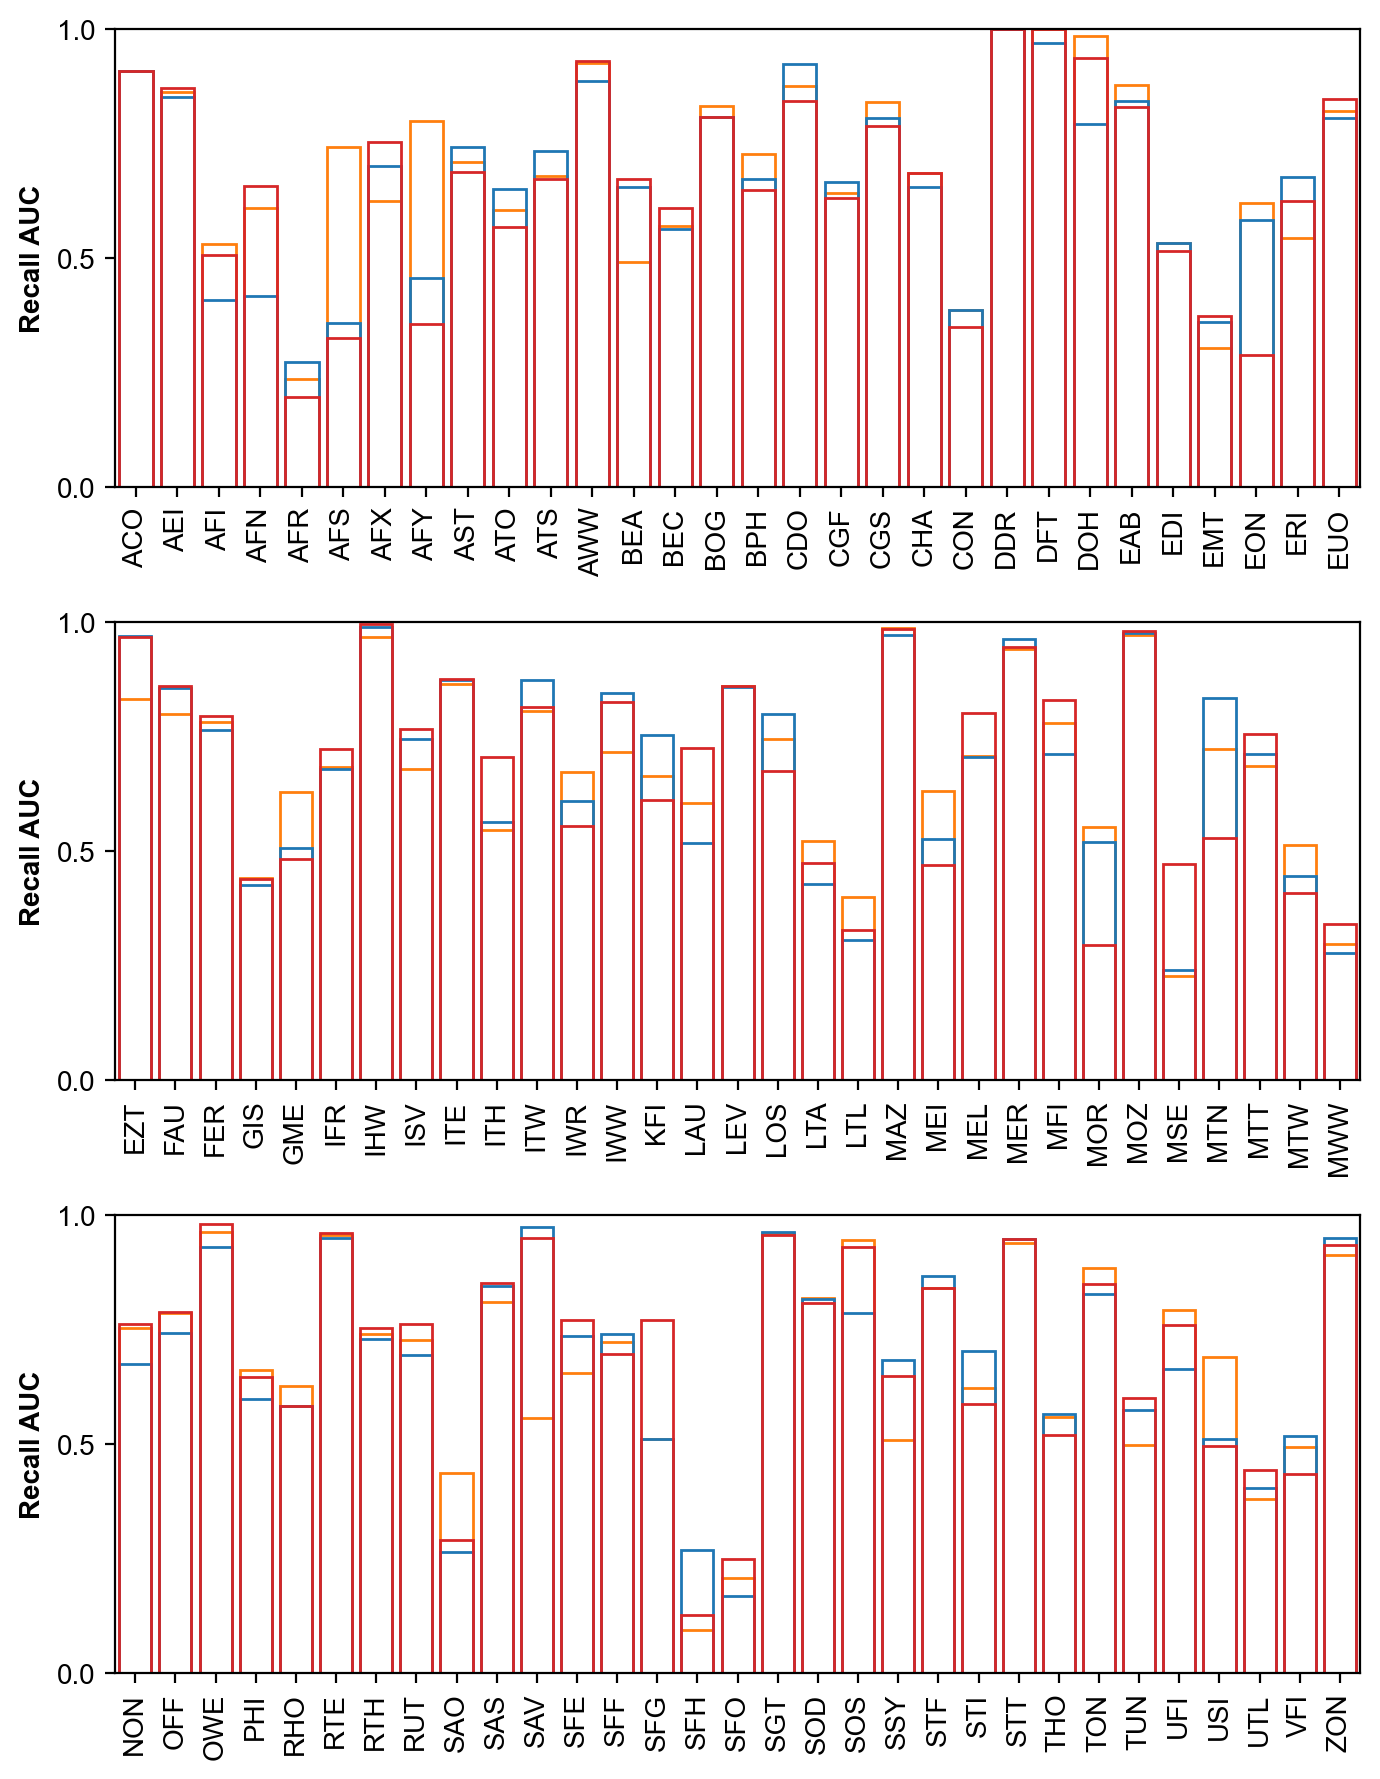

In [61]:
metric_colors = {
    "E_T": "#d62728",
    "E_fT": "#1f77b4",
    "dE_fS": "#ff7f0e",
}
fig, ax_fig = plt.subplots(3, 1, figsize=(7, 9))

zeo_ranges = [
    [0, len(auc_comp) // 3],
    [len(auc_comp) // 3, 2 * len(auc_comp) // 3],
    [2 * len(auc_comp) // 3, len(auc_comp)],
]

for i, ax in enumerate(ax_fig):
    #     ax.spines['left'].set_visible(False)

    start, end = zeo_ranges[i]
    for y in metrics:
        sns.barplot(
            auc_comp[y][start:end],
            ax=ax,
            edgecolor=metric_colors[y],
            facecolor=(1, 1, 1, 0),
        )

    ax.set_ylabel("Recall AUC", fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.5, 1])

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

fig.savefig("images/auc_comparison.svg", bbox_inches="tight")

Publication counts are available on https://zeodb.mit.edu, which contains datasets from Schwalbe-Koda et al., Science (2021) DOI: [10.1126/science.abh3350](https://doi.org/10.1126/science.abh3350) and from Jensen et al., ACS. Cent. Sci. (2021) DOI: [10.1021/acscentsci.1c00024](https://doi.org/10.1021/acscentsci.1c00024).

In [70]:
pubcounts = pd.read_csv("../data/pub_counts.csv", index_col=0)
pubs = pubcounts.to_dict()["pub_counts"]

{'AFI': 156,
 'CHA': 103,
 'MFI': 93,
 'BEA': 87,
 'AEL': 58,
 'LTA': 54,
 'FER': 48,
 'MTW': 47,
 'AEI': 46,
 'LEV': 43,
 'MWW': 41,
 'MOR': 36,
 'EUO': 35,
 'MEL': 35,
 'BEC': 34,
 'TON': 33,
 'AST': 31,
 'ITH': 27,
 'SOD': 23,
 'STF': 23,
 'EMT': 22,
 'NON': 21,
 'RTH': 21,
 'IFR': 20,
 'MRE': 20,
 'STO': 20,
 'FAU': 20,
 'ITW': 19,
 'GIS': 19,
 'MTT': 16,
 'ATO': 16,
 'ITE': 16,
 'ATS': 15,
 'STT': 15,
 'AFX': 14,
 'IWW': 14,
 'CON': 14,
 'IWR': 14,
 'OFF': 14,
 'AFO': 12,
 'VFI': 11,
 'RHO': 11,
 'SAS': 9,
 'DDR': 9,
 'ERI': 9,
 'UTL': 9,
 'STI': 8,
 'IMF': 8,
 'SFO': 8,
 'MEI': 7,
 'RUT': 7,
 'AFS': 7,
 'SGT': 7,
 'AFN': 7,
 'TUN': 7,
 'VET': 7,
 'ETL': 6,
 'KFI': 6,
 'ITT': 6,
 'SFF': 6,
 'BPH': 6,
 'DOH': 5,
 'DFT': 5,
 'ZON': 5,
 'CGS': 5,
 'AEN': 5,
 'MER': 5,
 'IFO': 5,
 'SFE': 5,
 'LTL': 4,
 'MAZ': 4,
 'EON': 4,
 'AFY': 4,
 'AWO': 4,
 'LAU': 4,
 'ISV': 4,
 'MSE': 4,
 'STW': 4,
 'GME': 4,
 'AWW': 3,
 'USI': 3,
 'UFI': 3,
 'SFS': 3,
 'UOV': 3,
 'PHI': 3,
 'SFH': 3,
 'SFW': 3,

In [82]:
form_energy_df = pd.read_csv("../data/form_E.csv", index_col=0)
form_energy = dict(form_energy_df[["framework", "formation_E"]].to_numpy())

In [83]:
auc_comp["pubs"] = auc_comp.index.map(pubs)
auc_comp["E_F"] = auc_comp.index.map(form_energy)

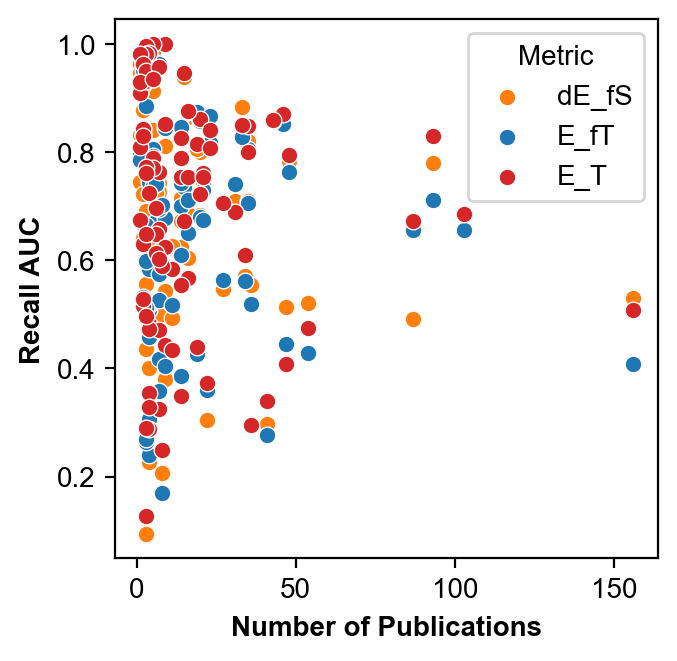

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

for metric in metrics:
    sns.scatterplot(
        x="pubs",
        y=metric,
        data=auc_comp,
        label=metric,
        color=metric_colors[metric],
        ax=ax,
    )
ax.set_xlabel(
    "Number of Publications",
    fontweight="bold",
)
ax.set_ylabel("Recall AUC", fontweight="bold")
ax.legend(title="Metric", loc="upper right")
fig.savefig("images/auc_vs_pubs.svg", bbox_inches="tight")

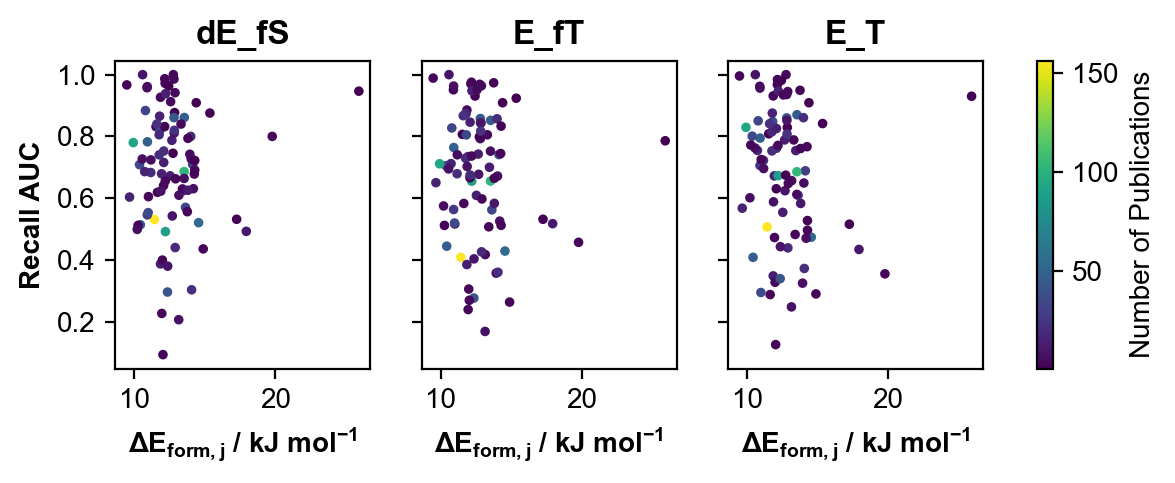

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2), sharey=True)


for metric in metrics:
    im = ax[metrics.index(metric)].scatter(
        auc_comp["E_F"], auc_comp[metric], c=auc_comp["pubs"], cmap="viridis", s=6
    )
    ax[metrics.index(metric)].set_xlabel(
        "$\mathdefault{\Delta E}_{\mathdefault{form,j}}$ / kJ mol$^{\mathdefault{-1}}$",
        fontweight="bold",
    )
    if metrics.index(metric) == 0:
        ax[metrics.index(metric)].set_ylabel("Recall AUC", fontweight="bold")
    ax[metrics.index(metric)].set_title(metric, fontweight="bold")

fig.colorbar(im, ax=ax.ravel().tolist(), label="Number of Publications")
fig.savefig("images/auc_vs_dE_form.svg", bbox_inches="tight")

In [62]:
# get statistics for the best model
full_df[best_sisso].describe()

count    7.478900e+04
mean              inf
std               NaN
min     -1.495630e+13
25%     -2.145043e-01
50%     -1.431840e-01
75%     -9.948196e-02
max               inf
Name: sisso_13229, dtype: float64

In [63]:
alt_best_sisso = "l_neg_" + best_sisso
mini_df = full_df[["Zeolite", "SMILES", best_sisso, "E_T", "dE_fS", "syn"]]
mini_df[alt_best_sisso] = np.log(-1 * mini_df[best_sisso])
len(mini_df)

/tmp/ipykernel_1231508/2201177205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df[alt_best_sisso] = np.log(-1 * mini_df[best_sisso])


74789

Sometimes there are random variations in the logistic and decision tree fits, but over several trials, these are the best two expressions that I have found.

In [64]:
sisso_expressions[16878]

'((lC_fS/(lD_Om*lD_fS))-(dE_fS/dE_fOm))'

In [65]:
sisso_expressions[13229]

'((lC_fS/(lD_Om*lD_fS))-(dE_S/dE_Om))'

So our unitless SISSO expression is:

$$ \alpha_T = \frac{\ln{C_{form,Si}}}{\ln{D_{OSDA,mol}} \times \ln{D_{form,Si}}} - \frac{E_{ij, Si}}{E_{ij, OSDA mol}}$$

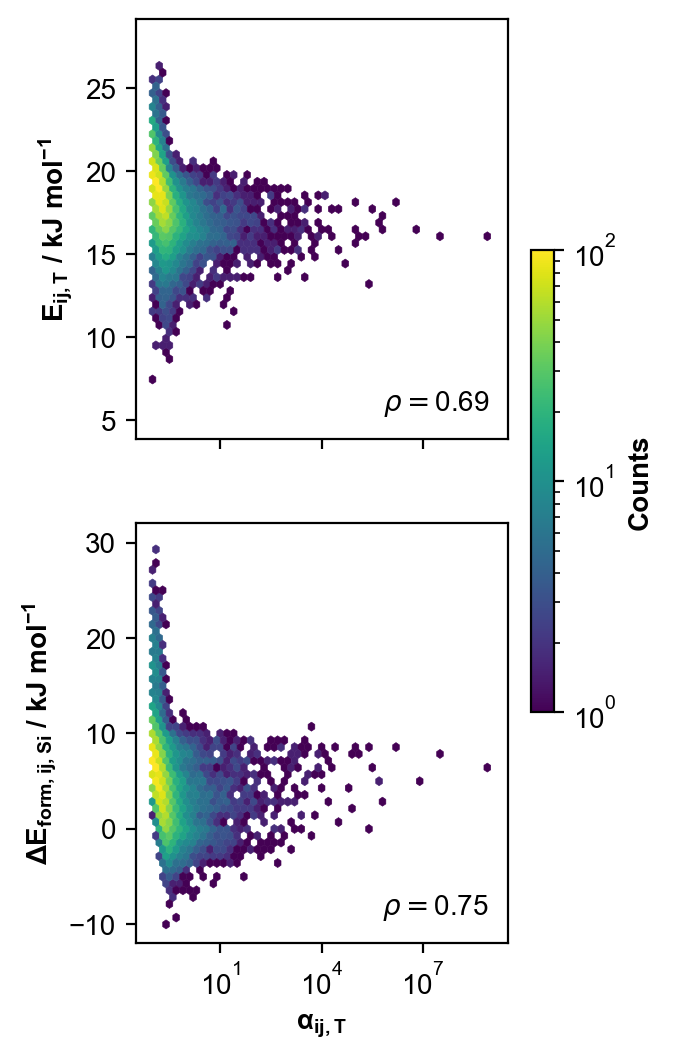

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(3, 6), sharex=True)
cmap = mpl.colormaps["viridis"]
normalizer = mpl.colors.LogNorm(vmin=1, vmax=100)
scalar_mappable = cm.ScalarMappable(norm=normalizer, cmap=cmap)

# compute spearman correlation for both plots
template_spearman = full_df[best_sisso].corr(full_df["E_T"], method="spearman")
form_aff_spearman = full_df[best_sisso].corr(full_df["dE_fS"], method="spearman")

im = ax[0].hexbin(
    -1 * mini_df[best_sisso],
    mini_df["E_T"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    xscale="log",
    linewidths=0.2,
    extent=(-1, 9, 5, 28),
)
ax[0].set_ylabel(
    "E$_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
ax[0].annotate(
    r"$\rho =$" f"{template_spearman:.2f}",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=10,
)

im = ax[1].hexbin(
    -1 * mini_df[best_sisso],
    mini_df["dE_fS"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    xscale="log",
    linewidths=0.2,
    extent=(-1, 9, -10, 30),
)
ax[1].set_xlabel("$\mathdefault{\\alpha}_{\mathdefault{ij,T}}$", fontweight="bold")
ax[1].set_ylabel(
    "$\mathdefault{\Delta E}_{\mathdefault{form,ij,Si}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
ax[1].annotate(
    r"$\rho =$" f"{form_aff_spearman:.2f}",
    xy=(0.95, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize=10,
)

cb = fig.colorbar(scalar_mappable, ax=ax.ravel().tolist(), shrink=0.5)
cb.set_label("Counts", fontweight="bold")

plt.show()

In [88]:
alt_best_sisso = "l_neg_" + best_sisso
rmdf = full_df[["Zeolite", "SMILES", best_sisso, "E_T", "dE_fS", "syn"]]
rmdf = remove_outliers(rmdf, best_sisso, n_std=100)
rmdf[alt_best_sisso] = np.log(-1 * mini_df[best_sisso])
len(rmdf)

74789

In [89]:
rmdf = rmdf.replace([np.inf, -np.inf], np.nan).dropna()

In [90]:
rmdf[best_sisso].describe()

count    74371.000000
mean        -0.229726
std          0.521216
min        -11.610962
25%         -0.212883
50%         -0.142586
75%         -0.099251
max         -0.015846
Name: sisso_13229, dtype: float64

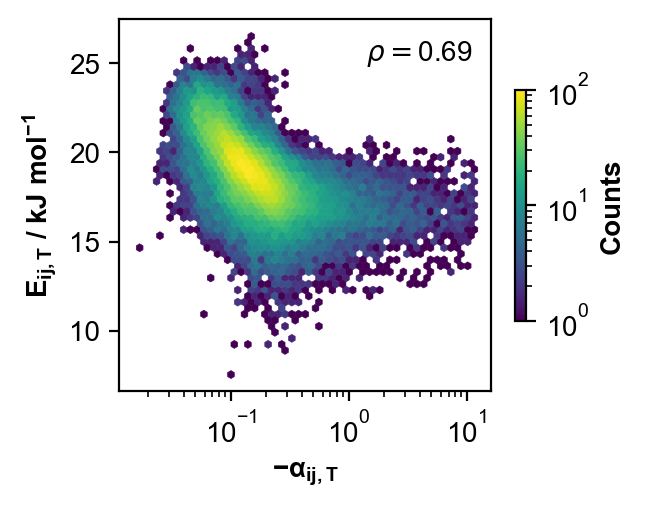

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
cmap = mpl.colormaps["viridis"]
normalizer = mpl.colors.LogNorm(vmin=1, vmax=100)
scalar_mappable = cm.ScalarMappable(norm=normalizer, cmap=cmap)

# compute spearman correlation for both plots
template_spearman = rmdf[best_sisso].corr(rmdf["E_T"], method="spearman")

im = ax.hexbin(
    -rmdf[best_sisso],
    rmdf["E_T"],
    gridsize=50,
    cmap="viridis",
    mincnt=1,
    bins="log",
    xscale="log",
    linewidths=0.2,
    # extent=(-2, 1, -10, 10),
)
ax.set_ylabel(
    "E$_{\mathdefault{ij,T}}$ / kJ mol$^{\mathdefault{-1}}$",
    fontweight="bold",
)
ax.set_xlabel("$\mathdefault{\minus \\alpha}_{\mathdefault{ij,T}}$", fontweight="bold")
ax.annotate(
    r"$\rho =$" f"{template_spearman:.2f}",
    xy=(0.95, 0.95),
    xycoords="axes fraction",
    ha="right",
    va="top",
    fontsize=10,
)

cb = fig.colorbar(scalar_mappable, ax=ax, shrink=0.5)
cb.set_label("Counts", fontweight="bold")
ax.set_box_aspect(1)
fig.savefig("images/alpha_vs_E_T.svg", dpi=300, bbox_inches="tight")
plt.show()

In [92]:
idxmin = rmdf.groupby(["Zeolite", "SMILES"]).idxmin()

In [94]:
idxmin.head()

sisso_13229  E_T  dE_fS  syn  l_neg_sisso_13229
Zeolite SMILES                                                 
ACO     CCCCCN            0    0      0    0                  0
        CCCCN             4    4      4    4                  4
        CCCCO             9    9      9    9                  9
        CCNC              8    8      8    8                  8
        CCNCC             3    3      3    3                  3

0it [00:00, ?it/s]

2it [00:00, 72.76it/s]


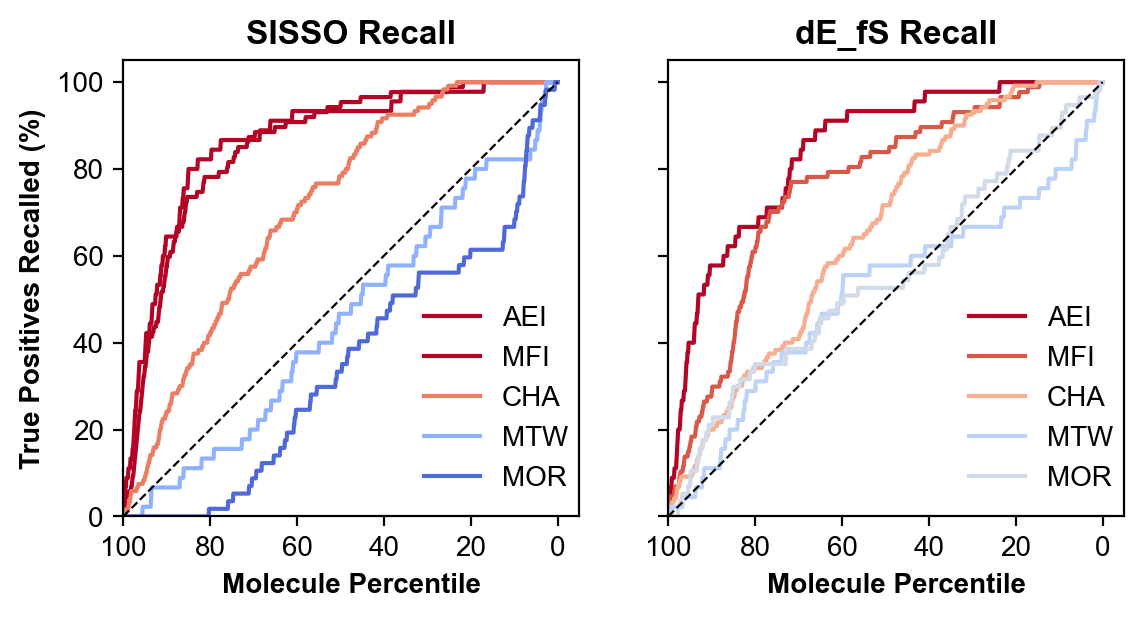

In [126]:
norm = mpl.colors.Normalize(vmin=0.3, vmax=0.85)
cmap = cm.coolwarm
to_plot = ["AEI", "MFI", "CHA", "MTW", "MOR"]

fig, ax = plot_recall_curves(
    lit_df=rmdf,
    idxmin=idxmin,
    metrics=[best_sisso, "dE_fS"],
    plot_items=to_plot,
    substance="zeolite",
    cmap=cmap,
    size=3,
)

# DSK templating
ax[0].set_title("SISSO Recall", fontweight="bold")
ax[1].set_title("dE_fS Recall", fontweight="bold")

fig.tight_layout()
fig.savefig("images/recall_examples_sisso_update.svg", bbox_inches="tight")
plt.show()

# Check the best equations for the salient variables that appear

In this section, I want to count the number of each variable that appears in the top SISSO equations and plot the counts in a bar chart.

In [96]:
top_sisso_auc = [col for col in auc_avg.index if "sisso" in col]
best_sisso_idx = [int(eq.split("_")[1]) for eq in top_sisso_auc[:100]]

In [97]:
wrong_vars = [
    "syn",
    "crystal_id",
    "Zeolite",
    "SMILES",
    "Ligand formula",
    "Loading",
    "ligand_atoms",
    "Si_count",
]
act_variable_names = [nn for nn in variable_names if nn not in wrong_vars]

In [98]:
var_counts = {k: 0 for k in act_variable_names}
top_auc_expr = []

for i in best_sisso_idx:
    eq = sisso_expressions[i]
    top_auc_expr.append(eq)
    for var in variable_names:
        if var in eq:
            var_counts[var] += 1

In [99]:
full_var_name_map = {
    "E_F": "$\mathdefault{\Delta E}_{\mathdefault{form,j}}$",
    "dE_Oa": "$\mathdefault{\Delta E}_{\mathdefault{ij,OSDA,atom}}$",
    "dE_Om": "$\mathdefault{\Delta E}_{\mathdefault{ij,OSDA,mol}}$",
    "dE_S": "$\mathdefault{\Delta E}_{\mathdefault{ij,Si}}$",
    "dE_fOa": "$\mathdefault{\Delta E}_{\mathdefault{form,ij,OSDA,atom}}$",
    "dE_fOm": "$\mathdefault{\Delta E}_{\mathdefault{form,ij,OSDA,mol}}$",
    "dE_fS": "$\mathdefault{\Delta E}_{\mathdefault{form,ij,Si}}$",
    "lC_Oa": "$\mathdefault{ln C}_{\mathdefault{OSDA,atom}}$",
    "lC_Om": "$\mathdefault{ln C}_{\mathdefault{OSDA,mol}}$",
    "lC_S": "$\mathdefault{ln C}_{\mathdefault{Si}}$",
    "lD_Oa": "$\mathdefault{ln D}_{\mathdefault{OSDA,atom}}$",
    "lD_Om": "$\mathdefault{ln D}_{\mathdefault{OSDA,mol}}$",
    "lD_S": "$\mathdefault{ln D}_{\mathdefault{Si}}$",
    "lC_fOa": "$\mathdefault{ln C}_{\mathdefault{form,OSDA,atom}}$",
    "lC_fOm": "$\mathdefault{ln C}_{\mathdefault{form,OSDA,mol}}$",
    "lC_fS": "$\mathdefault{ln C}_{\mathdefault{form,Si}}$",
    "lD_fOa": "$\mathdefault{ln D}_{\mathdefault{form,OSDA,atom}}$",
    "lD_fOm": "$\mathdefault{ln D}_{\mathdefault{form,OSDA,mol}}$",
    "lD_fS": "$\mathdefault{ln D}_{\mathdefault{form,Si}}$",
}

In [100]:
bar_df = pd.DataFrame(
    {"Variable": [full_var_name_map[i] for i in var_counts], "Count": var_counts.values()}
).sort_values(by="Count", ascending=False)
# drop any variables that have a Count of 0
bar_df = bar_df[bar_df["Count"] > 0]
bar_df

,Variable,Count
11,"$\mathdefault{ln D}_{\mathdefault{OSDA,mol}}$",69
4,"$\mathdefault{\Delta E}_{\mathdefault{form,ij,...",62
3,"$\mathdefault{\Delta E}_{\mathdefault{ij,Si}}$",59
13,"$\mathdefault{ln C}_{\mathdefault{form,OSDA,at...",37
5,"$\mathdefault{\Delta E}_{\mathdefault{form,ij,...",35
1,"$\mathdefault{\Delta E}_{\mathdefault{ij,OSDA,...",32
15,"$\mathdefault{ln D}_{\mathdefault{form,Si}}$",31
10,"$\mathdefault{ln D}_{\mathdefault{OSDA,atom}}$",24
0,"$\mathdefault{\Delta E}_{\mathdefault{form,j}}$",18
14,"$\mathdefault{ln C}_{\mathdefault{form,Si}}$",16


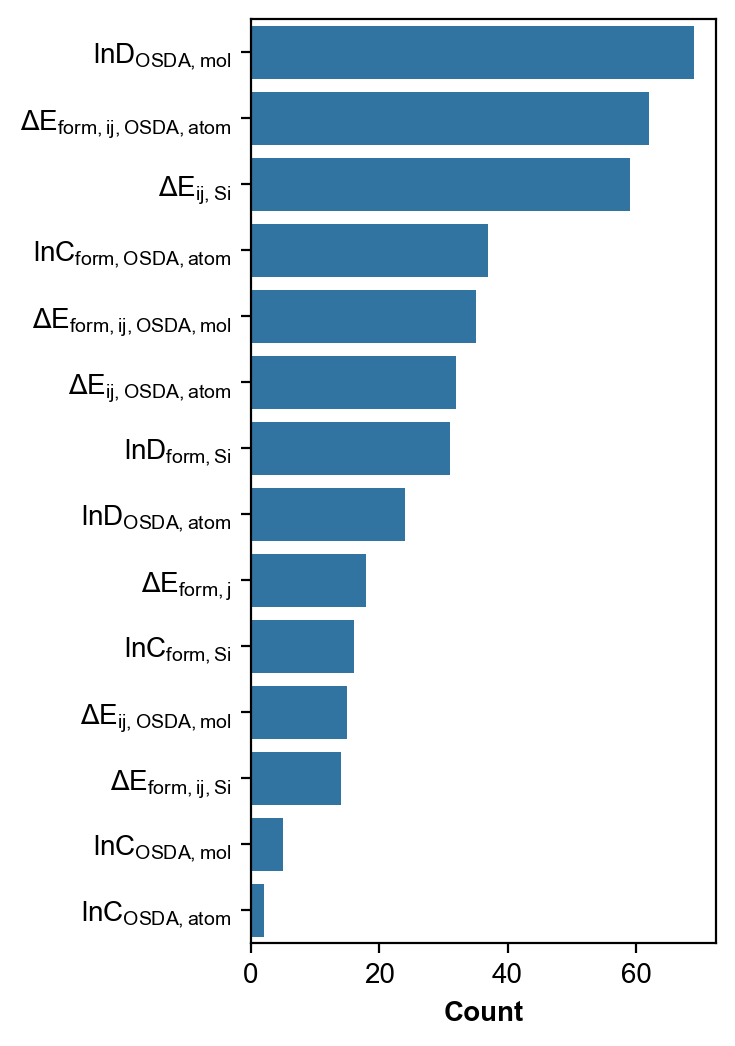

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

sns.barplot(x=bar_df["Count"], y=bar_df["Variable"], ax=ax)
ax.set_xlabel("Count", fontweight="bold")
ax.set_ylabel("")
fig.savefig("images/sisso_variable_counts.svg", bbox_inches="tight")

In [102]:
with open("top_auc_exprs.txt", "w") as f:
    for eq in top_auc_expr:
        f.write(eq + "\n")

In [103]:
fhand = "../data/sisso_ranks.csv"
if os.path.exists(fhand):
    sisso_rank_df = pd.read_csv(fhand)
    # print the ranking of the best expressions from sisso_rank_df
    sisso_rank_df.loc[sisso_rank_df["sisso_model"].isin(top_sisso_auc[:100])].describe()

# Additional analysis of SISSO things

- contribution of different expressions within the SISSO descriptor $\alpha_T$
- effect of BE distribution on $\log{D}$

## Import the data and equations

In [104]:
print(e, pi, sqrt(2), log(2))

2.718281828459045 3.141592653589793 1.4142135623730951 0.6931471805599453


In [105]:
mdf = pd.read_csv("../data/clean_all_data.csv")
print(len(mdf))
mdf.head()

74789


,crystal_id,Zeolite,SMILES,Ligand formula,Loading,dE_S,dE_Om,Templating,Volume (Angstrom3),syn,...,lC_fOa,lC_fS,lD_fOa,lD_fS,lC_Om,lD_Om,lC_AOm,lD_AOm,lC_fOm,lD_fOm
0,137337790,ACO,CCCCCN,C5H13N,2,-0.792990,-6.343916,19.428617,107.680,0.0,...,-3.763081,-5.177063,-5.462692,-7.613363,-21.215128,-40.662536,-24.096644,-51.616742,-32.810746,-36.236019
1,137353625,ACO,Cc1ccncc1,C6H7N,2,-3.000776,-24.006207,18.325914,96.232,0.0,...,-3.998696,-4.513224,-5.956683,-7.434522,-15.904415,-33.432341,-18.533953,-43.677207,-27.500033,-36.977180
2,137369986,ACO,NCCOCCO,C4H11NO2,3,-7.733204,-41.243755,15.525417,108.720,0.0,...,-2.634592,-3.090273,-4.440724,-5.831656,-10.721414,-33.119391,-14.687604,-43.094288,-10.776070,-20.026711
3,137352553,ACO,CCNCC,C4H11N,2,-2.536347,-20.290778,18.026902,91.104,0.0,...,-3.823833,-4.652868,-5.517742,-7.004148,-17.021574,-29.886585,-18.562155,-39.813323,-28.617192,-30.623784
4,139638010,ACO,CCCCN,C4H11N,3,-1.885987,-10.058597,19.195592,90.800,0.0,...,-3.294812,-4.848419,-5.252069,-7.667084,-20.098195,-38.772090,-21.736081,-45.225110,-20.152850,-27.230365


## Check the scale of the different expressions in $\alpha_T$

The best performing equation from SISSO is:
$$ \alpha_T = \frac{\ln{C_{\text{form,Si}}}}{\ln{D_{\text{OSDA,mol}}} \times \ln{D_{\text{form,Si}}}} - \frac{\Delta E_{ij, \text{Si}}}{\Delta E_{ij, \text{OSDA, mol}}} $$
I'm going to see how each part of this equation contributes to predictions.

In [106]:
mdf = mdf.replace([np.inf, -np.inf], np.nan).dropna()
len(mdf)

74786

In [107]:
mdf.columns

Index(['crystal_id', 'Zeolite', 'SMILES', 'Ligand formula', 'Loading', 'dE_S',
       'dE_Om', 'Templating', 'Volume (Angstrom3)', 'syn', 'TdS_ads',
       'ligand_atoms', 'dE_Oa', 'E_F', 'Si_count', 'dA_Om', 'dA_Oa', 'dA_S',
       'dE_fOm', 'dE_fOa', 'dE_fS', 'dA_fS', 'E_T', 'E_fT', 'A_T', 'lC_Oa',
       'lC_S', 'lD_Oa', 'lD_S', 'lC_AOa', 'lC_AS', 'lD_AOa', 'lD_AS', 'lC_fOa',
       'lC_fS', 'lD_fOa', 'lD_fS', 'lC_Om', 'lD_Om', 'lC_AOm', 'lD_AOm',
       'lC_fOm', 'lD_fOm'],
      dtype='object')

In [108]:
mdf["sisso_pt1"] = mdf["lC_fS"] / (mdf["lD_Om"] * mdf["lD_fS"])
mdf["sisso_pt2"] = mdf["dE_S"] / mdf["dE_Om"]

In [109]:
mdf = mdf.replace([np.inf, -np.inf], np.nan).dropna()
len(mdf)

74785

In [110]:
mdf[["sisso_pt1", "sisso_pt2"]].describe()

,sisso_pt1,sisso_pt2
count,7.478500e+04,74785.000000
mean,-2.000006e+08,0.053000
std,5.469113e+10,0.028634
min,-1.495630e+13,0.005208
25%,-1.504961e-01,0.031250
50%,-8.664572e-02,0.050000
75%,-4.979313e-02,0.062500
max,0.000000e+00,0.437500


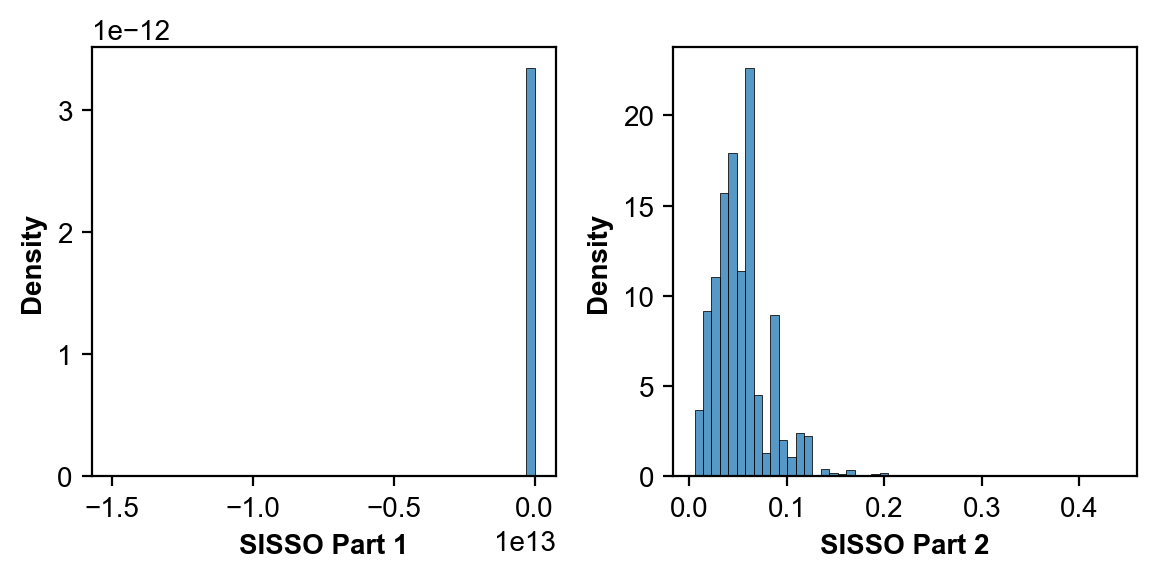

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.histplot(mdf["sisso_pt1"], bins=50, ax=axes[0], stat="density")
sns.histplot(mdf["sisso_pt2"], bins=50, ax=axes[1], stat="density")
for ax in axes:
    ax.set_ylabel("Density", fontweight="bold")
axes[0].set_xlabel("SISSO Part 1", fontweight="bold")
axes[1].set_xlabel("SISSO Part 2", fontweight="bold")
plt.tight_layout()

The distribution for the first part of the SISSO equation seems to be skewed a lot, so we should probably remove any obvious outliers.

In [112]:
# drop rows where sisso_pt1 < -10 (since the median is -0.08 and the IQR is ~0.1)
rdf = remove_outliers(mdf, "sisso_pt1", n_std=100)
print(len(mdf), len(rdf))

74785 74785


In [113]:
rdf["sisso_pt1"].describe()

count    74337.000000
mean        -0.172166
std          0.473328
min        -10.073650
25%         -0.148726
50%         -0.086052
75%         -0.049590
max          0.000000
Name: sisso_pt1, dtype: float64

In [114]:
# drop rows where sisso_pt1 < -10 (since the median is -0.08 and the IQR is ~0.1)
mdf = mdf[mdf["sisso_pt1"] > -10]
len(mdf)

74335

In [115]:
# drop outliers more than 3 std dev away from the median for sisso_pt1
mdf = mdf[np.abs(mdf["sisso_pt1"] - mdf["sisso_pt1"].median()) <= 3.0 * mdf["sisso_pt1"].std()]
len(mdf)

73404

In [116]:
mdf[["sisso_pt1", "sisso_pt2"]].describe()

,sisso_pt1,sisso_pt2
count,73404.000000,73404.000000
mean,-0.129535,0.053214
std,0.154837,0.028711
min,-1.492229,0.005208
25%,-0.145156,0.031250
50%,-0.084947,0.050000
75%,-0.049209,0.062500
max,0.000000,0.437500


In [117]:
spearman = rdf[["sisso_pt1", "sisso_pt2"]].corr(method="spearman") ** 2

In [118]:
rho = spearman.min().iloc[0]

In [119]:
spearman = mdf[["sisso_pt1", "sisso_pt2"]].corr(method="spearman") ** 2

In [120]:
rho = spearman.min().iloc[0]

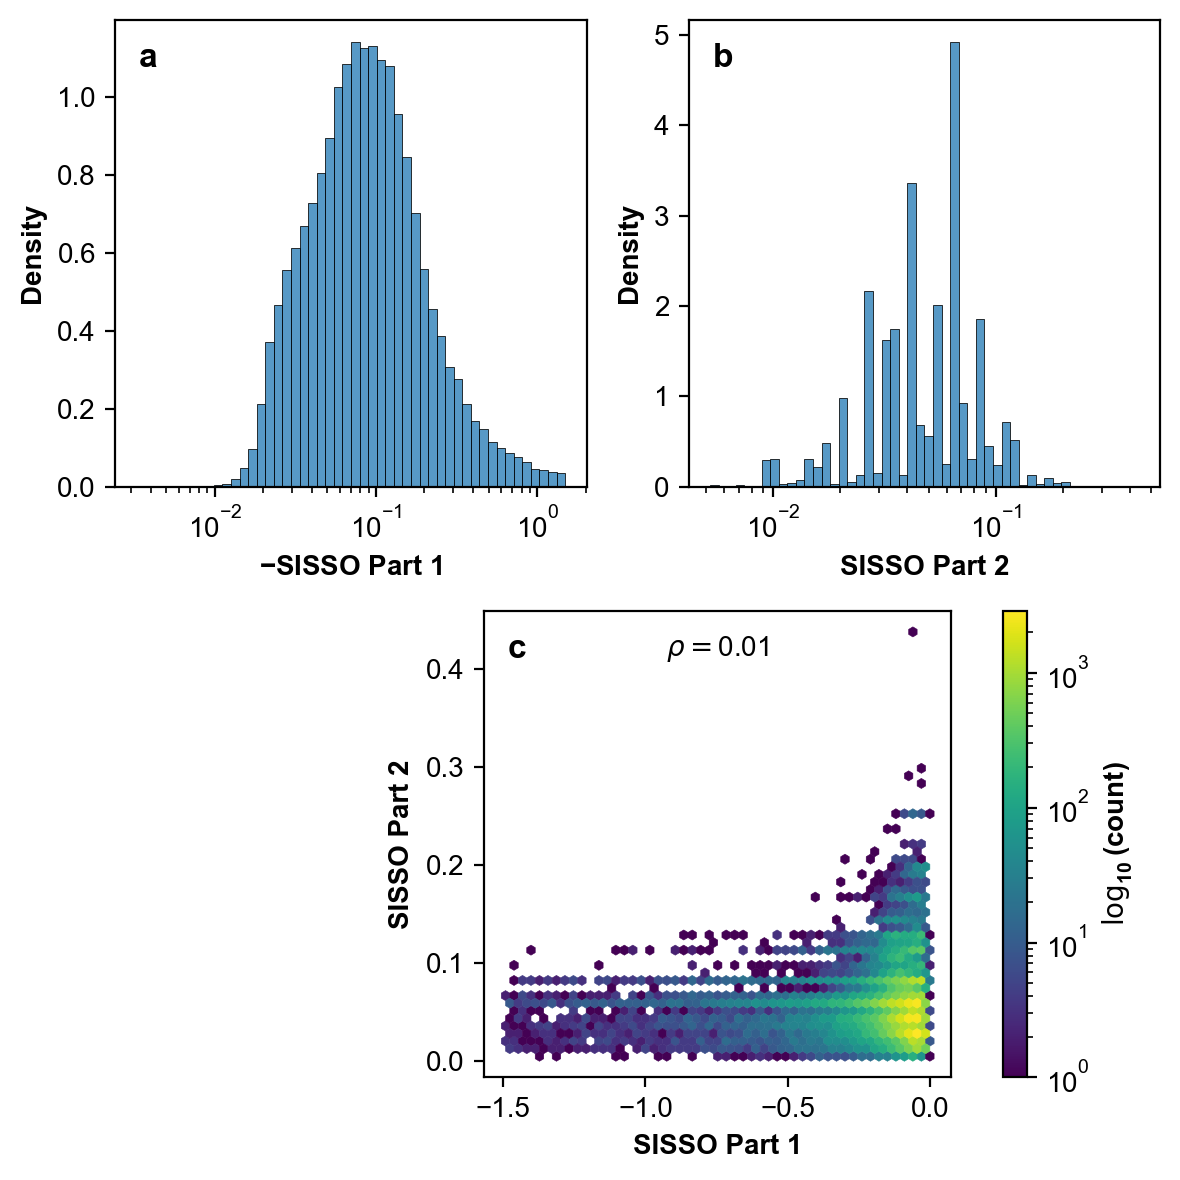

In [127]:
fig, axes = plt.subplot_mosaic([["left", "right"], ["bottom"] * 2], figsize=(6, 6))
sns.histplot(-mdf["sisso_pt1"], bins=50, ax=axes["left"], stat="density", log_scale=True)
sns.histplot(mdf["sisso_pt2"], bins=50, ax=axes["right"], stat="density", log_scale=True)
axes["left"].set_ylabel("Density", fontweight="bold")
axes["right"].set_ylabel("Density", fontweight="bold")
axes["left"].set_xlabel("$\mathdefault{-}$SISSO Part 1", fontweight="bold")
axes["right"].set_xlabel("SISSO Part 2", fontweight="bold")
axes["left"].annotate(
    "a",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    ha="left",
    va="top",
    fontsize=12,
    fontweight="bold",
)
axes["right"].annotate(
    "b",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    ha="left",
    va="top",
    fontsize=12,
    fontweight="bold",
)
im = axes["bottom"].hexbin(
    mdf["sisso_pt1"],
    mdf["sisso_pt2"],
    gridsize=50,
    cmap="viridis",
    bins="log",
    edgecolors="face",
    mincnt=1,
    linewidths=0.2,
    # xscale="log",
    # yscale="log",
)
axes["bottom"].set_xlabel("SISSO Part 1", fontweight="bold")
axes["bottom"].set_ylabel("SISSO Part 2", fontweight="bold")
axes["bottom"].set_box_aspect(1)
axes["bottom"].annotate(
    r"$\rho =$" f"{rho:.2f}",
    xy=(0.5, 0.95),
    xycoords="axes fraction",
    ha="center",
    va="top",
    fontsize=10,
)
axes["bottom"].annotate(
    "c",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    ha="left",
    va="top",
    fontsize=12,
    fontweight="bold",
)

cbar = plt.colorbar(im, ax=axes["bottom"])
cbar.set_label("$\mathdefault{\log_{10}}$(count)", fontweight="bold")

fig.tight_layout()
fig.savefig("images/sisso_terms_correlation.svg", dpi=300, bbox_inches="tight")
plt.show()

## Make a plot showing how inverse log directivity per OSDA mol correlates with BE for a hypothetical group of BEs

The hypothetical binding energies can be unitless, where they scale from $-100$ to $-10$ kJ mol $^{-1}$ or something, and be different types of mathematical series (geometric and uniform).

In [122]:
binding_df = pd.DataFrame(
    {
        "binding1": np.array([-100, -90, -80, -70, -60, -50, -40, -30, -20, -10])
        / (K_BOLTZMANN * SYNTH_TEMP),
        "binding2": np.array([-101 + 10 ** (1.8 - (i / 5)) for i in range(10)])
        / (K_BOLTZMANN * SYNTH_TEMP),
    }
)
binding_df

,binding1,binding2
0,-30.068087,-11.397088
1,-27.061279,-18.398447
2,-24.054470,-22.816006
3,-21.047661,-25.603298
4,-18.040852,-27.361960
5,-15.034044,-28.471600
6,-12.027235,-29.171736
7,-9.020426,-29.613492
8,-6.013617,-29.892221
9,-3.006809,-30.068087


In [123]:
for cc in [col for col in binding_df.columns if "log" not in col]:
    logd_name = cc + "_logd"
    logd_binding = 1 / np.log(softmax(-binding_df[cc].to_numpy()))
    binding_df[logd_name] = logd_binding
binding_df

,binding1,binding2,binding1_logd,binding2_logd
0,-30.068087,-11.397088,-19.718535,-0.050448
1,-27.061279,-18.398447,-0.327062,-0.077996
2,-24.054470,-22.816006,-0.164899,-0.118996
3,-21.047661,-25.603298,-0.110240,-0.178052
4,-18.040852,-27.361960,-0.082796,-0.259223
5,-15.034044,-28.471600,-0.066292,-0.363895
6,-12.027235,-29.171736,-0.055274,-0.488303
7,-9.020426,-29.613492,-0.047397,-0.622606
8,-6.013617,-29.892221,-0.041485,-0.753339
9,-3.006809,-30.068087,-0.036884,-0.868389


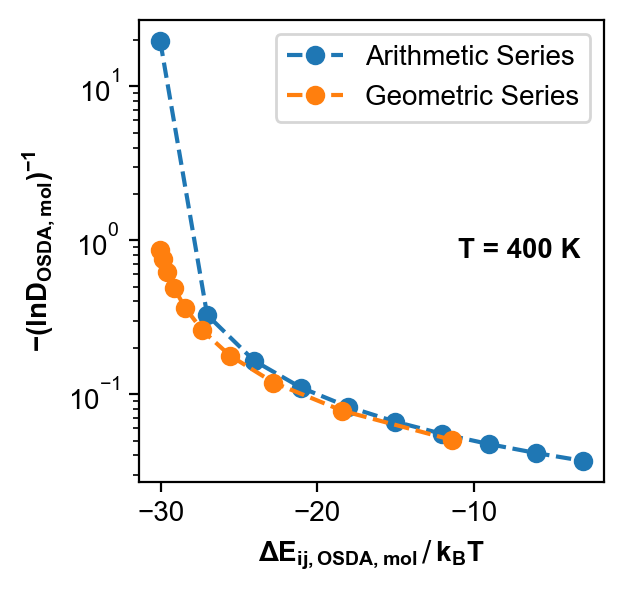

In [124]:
fig, axes = plt.subplots(1, figsize=(3, 3))
for cc in [col for col in binding_df.columns if "log" not in col]:
    logd_name = cc + "_logd"
    label = "Arithmetic Series" if cc == "binding1" else "Geometric Series"
    axes.plot(
        binding_df[cc],
        -binding_df[logd_name],
        label=label,
        marker="o",
        linestyle="--",
    )

axes.set_yscale("log")
axes.set_xlabel(
    "$\mathdefault{\Delta E}_{\mathdefault{ij,OSDA,mol}}\,/\,\mathdefault{k}_{\mathdefault{B}}\mathdefault{T}$",
    fontweight="bold",
)
axes.set_ylabel(
    "$\mathdefault{-(ln D}_{\mathdefault{OSDA,mol}}\mathdefault{)}^{\mathdefault{-1}}$",
    fontweight="bold",
)
axes.annotate(
    "T = 400 K",
    xy=(0.95, 0.5),
    xycoords="axes fraction",
    ha="right",
    va="center",
    fontsize=10,
    fontweight="bold",
)
axes.legend()